In [16]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn

In [17]:
#res in mm
res_mm = 1
#res in cm
res = 0.1
#fov in cm
fov_x = 25
fov_y = 25

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels = pixels_x*pixels_y
print(pixels_x)
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
echo_time = 5e-5

250


0.5405962334298786
0.0
0.2702981167149393


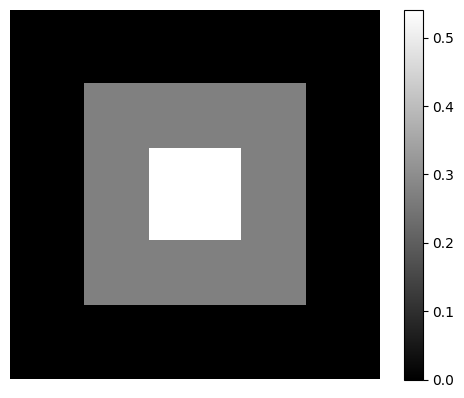

In [18]:
image = np.ones((pixels_x, pixels_y))

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

print(mxy_myelin)
print(mxy_wm)
print(mxy_mixed)

outer_square_size = int(1.0 * pixels_x) 
middle_square_size = int(0.6 * pixels_x)
inner_square_size = int(0.25 * pixels_x)  

# Calculate starting and ending indices for each square to center them
outer_start = (pixels_x - outer_square_size) // 2
outer_end = outer_start + outer_square_size

middle_start = (pixels_x - middle_square_size) // 2
middle_end = middle_start + middle_square_size

inner_start = (pixels_x - inner_square_size) // 2
inner_end = inner_start + inner_square_size

# Define the intensity values for each section
# Outermost square (100% WM - white, intensity = 1)
image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM

# Middle square (50/50 of WM and myelin - medium gray)
image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)

# Innermost square (100% myelin - black, intensity = 0)
image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)


# Display the image using matplotlib
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis
plt.colorbar()
plt.show()



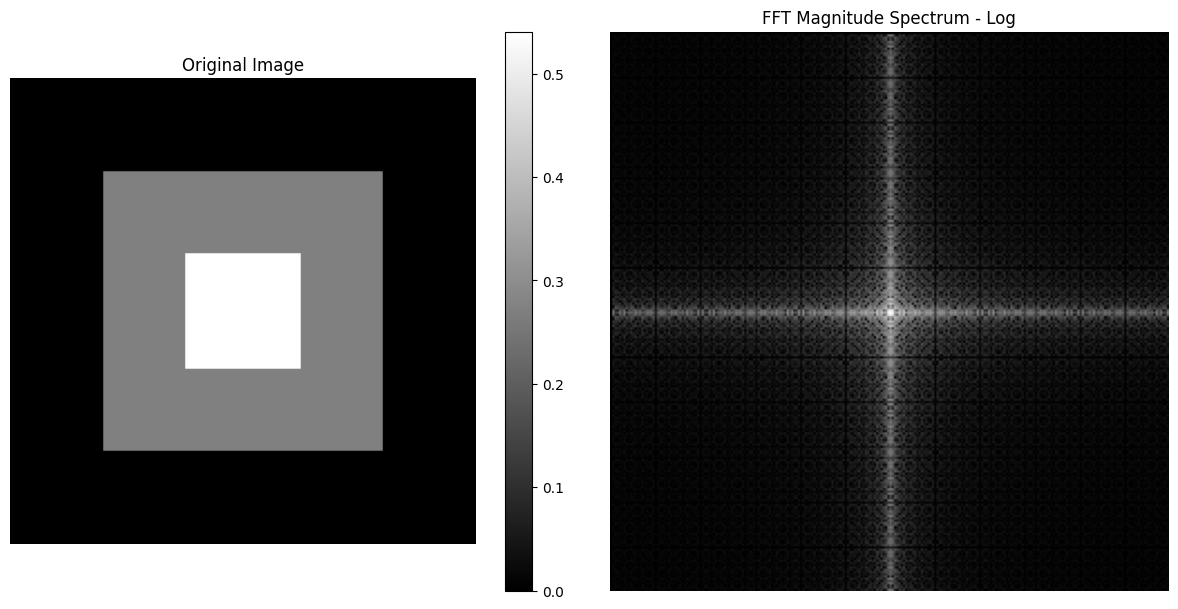

In [19]:
f_image = np.fft.fft2(image)

fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility

# Plot the original image and its FFT magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum - Log")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
filterwarnings("ignore") # ignore floor divide warnings
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


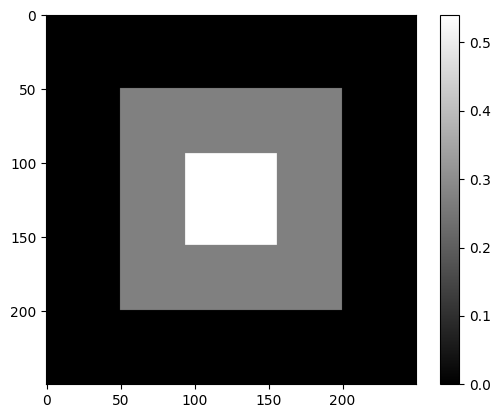

(250, 250) (250, 250)


In [21]:
# create a simple shepp logan phantom and plot it
#image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.colorbar()
plt.show()
im_size = image.shape
grid_size = im_size
print(im_size,grid_size)
#spokelength = image.shape[-1] * 2
#grid_size = (spokelength, spokelength)
#print(spokelength,grid_size)

In [22]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image_t = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image_t.shape))

image shape: torch.Size([1, 1, 250, 250])


(2, 90000)


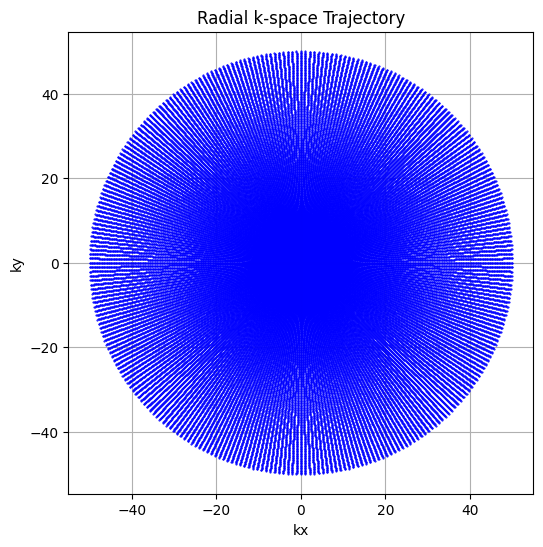

[[  0.           0.           0.         ...  -2.6002921   -2.60904729
   -2.61780249]
 [  0.           0.4180602    0.8361204  ... 124.13664841 124.55461692
  124.97258543]]


In [23]:
# Reset parameters for radial k-space sampling
#nspokes = int(np.pi*pixels_x*fov_x)+1 # Number of rays
nspokes = 300
num_samples_per_ray = 300 # Number of samples per ray

# Initialize an empty k-space list to store sampled points
k_space = np.zeros((nspokes * num_samples_per_ray,), dtype=complex)

# Create radial k-space sampling points (rays)
angles = np.linspace(0, 2 * np.pi, nspokes, endpoint=False)  # Angle of the rays
radii = np.linspace(0, pixels_x // 2, num_samples_per_ray)  # Radial distance (from the center)

# Prepare spatial coordinates
x_coords = np.arange(pixels_x)
y_coords = np.arange(pixels_y)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)  # Create a grid of image coordinates

# Flatten the image for efficient computation
image_flattened = image.flatten()

# Loop over rays to calculate Fourier coefficients
index = 0
kx_values = []
ky_values = []
for angle in angles:
    for radius in radii:
        # Calculate the kx, ky coordinates for each sampled point
        kx = radius * np.cos(angle)  # x-component in frequency domain
        ky = radius * np.sin(angle)  # y-component in frequency domain

        # Store kx and ky for density compensation
        kx_values.append(kx)
        ky_values.append(ky)
        
        # Compute the Fourier coefficient for this (kx, ky)
        #k_space[index] = np.sum(image_flattened * np.exp(-1j * 2 * np.pi * (kx * x_grid.flatten() / pixels_x + ky * y_grid.flatten() / pixels_y)))
        index += 1

# Convert kx_values and ky_values to numpy arrays
kx_values = np.array(kx_values)
ky_values = np.array(ky_values)

ktraj = np.stack((ky_values.flatten(), kx_values.flatten()), axis=0)
print(ktraj.shape)

# Visualize the radial k-space sampling points (this shows the rays)
plt.figure(figsize=(6, 6))
for angle in angles:
    x_vals = np.linspace(0, 50 * np.cos(angle), num_samples_per_ray)
    y_vals = np.linspace(0, 50 * np.sin(angle), num_samples_per_ray)
    plt.plot(x_vals, y_vals, 'b.', markersize=1)
plt.title('Radial k-space Trajectory')
plt.xlabel('kx')
plt.ylabel('ky')
plt.axis('equal')
plt.grid(True)
plt.show()
print(ktraj)


In [24]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 90000])


In [25]:
print(im_size,grid_size)

# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)

print(nufft_ob)
print(adjnufft_ob)

(250, 250) (250, 250)

KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (250, 250)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (250, 250)



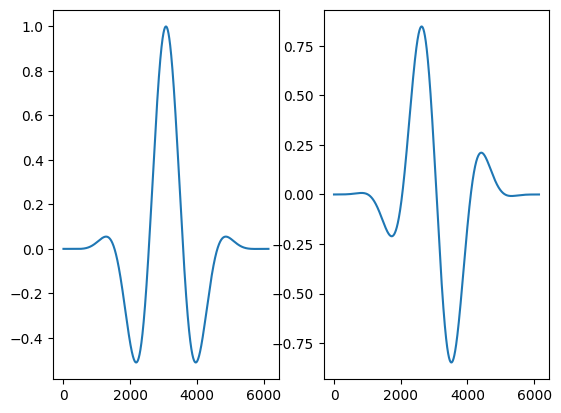

In [26]:
# plot the kernel
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
    
plt.show()

In [27]:
print(image_t.shape)

# Convert image_t to complex if it's real (with last dimension not equal to 2)
if image_t.ndimension() == 3 and image_t.shape[-1] != 2:  # Real input
    print("Converting real image to complex...")
    image_t = torch.stack([image_t, torch.zeros_like(image_t)], dim=-1)  # Convert to complex

print(image_t.shape)

# Check the dtype of image_t
print(image_t.dtype)

# If it's real, convert it to complex
if image_t.dtype != torch.complex128:
    print("Converting image to complex dtype...")
    image_t = image_t.to(torch.complex128)  # Convert to complex type

# Now pass the image to the nufft_ob function
kdata = nufft_ob(image_t, ktraj)
# calculate k-space data
kdata = nufft_ob(image_t, ktraj)
# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

torch.Size([1, 1, 250, 250])
torch.Size([1, 1, 250, 250])
torch.float64
Converting image to complex dtype...


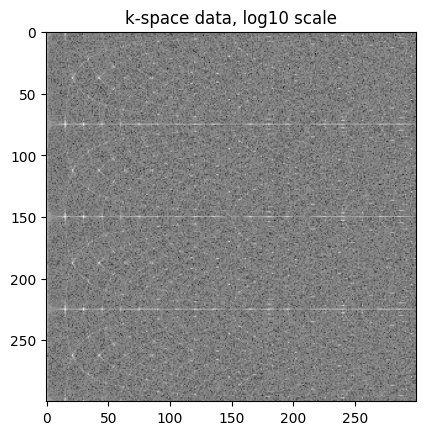

In [28]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes,num_samples_per_ray))
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()

In [29]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

(250, 250)
(250, 250)


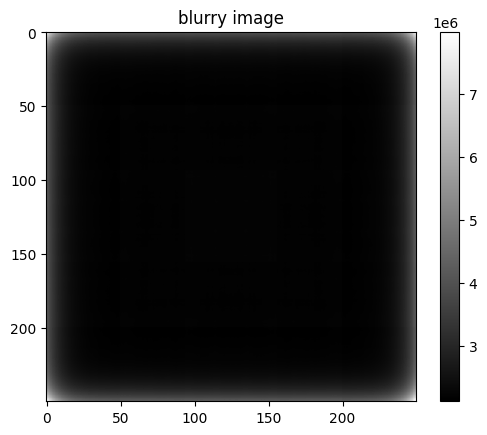

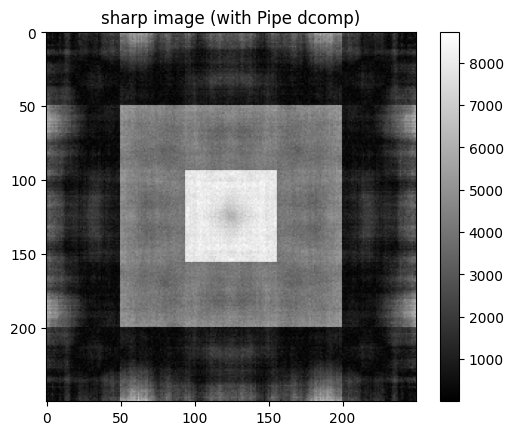

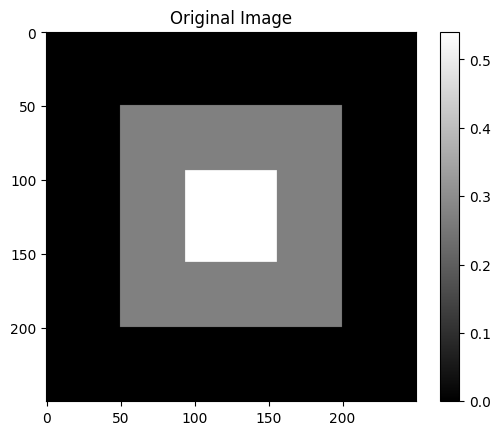

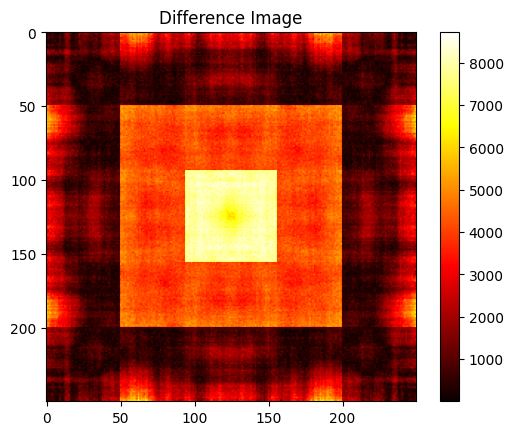

In [30]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

print(image_sharp_numpy.shape)
print(image.shape)

diff_image = np.abs(image_sharp - image)
diff_image = np.squeeze(diff_image)

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.colorbar()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.colorbar()
plt.title('sharp image (with Pipe dcomp)')

plt.figure(2)
plt.imshow(np.absolute(image))
plt.gray()
plt.colorbar()
plt.title('Original Image')

plt.figure(3)
plt.imshow(diff_image, cmap='hot')
plt.colorbar()
plt.title('Difference Image')

plt.show()


